<a href="https://colab.research.google.com/github/On-JungWoan/Flex_study/blob/main/naver_review_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **< 네이버 영화(해적: 도깨비 깃발) 감성분석 >**

## **0. 사용 모듈**

In [ ]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver

In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup as bs
import pandas as pd
from tqdm import tqdm
from konlpy.tag import Okt
from collections import Counter
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

okt = Okt()

## **1. Selenium, BS를 사용한 네이버 영화 리뷰 사이트 동적 웹 크롤링**

### 1) colab 환경 chrome driver 초기 설정



In [ ]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver', chrome_options=chrome_options)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: use options instead of chrome_options
  """


### 2) 영화 리뷰 사이트 크롤링

In [ ]:
url = 'https://movie.naver.com/movie/bi/mi/point.naver?code=194204'
driver.get(url)

frm = driver.find_element_by_class_name('ifr')
driver.switch_to.frame(frm)
# 댓글 알바 제외 및 최신 정보 반영을 위해 댓글 최신순으로 정렬
rcnt = driver.find_element_by_css_selector('#orderCheckbox > ul.sorting_list > li:nth-child(2) > a')
rcnt.click()

score_list = []
review_list = []
for cnt in tqdm(range(300)):

  for i in range(10):
    score = driver.find_element_by_css_selector('body > div > div > div.score_result > ul > li:nth-child('\
                                                +str(i+1)+') > div.star_score > em').text
    review = driver.find_element_by_id('_filtered_ment_'+str(i)).text
    score_list.append(score)
    review_list.append(review)

  next_but = driver.find_element_by_id('pagerTagAnchor'+str(cnt+2))
  next_but.click()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  import sys
  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
100%|██████████| 300/300 [05:14

### 3) 데이터 프레임 생성 및 전처리

- 결측치 처리

In [ ]:
df = pd.DataFrame({'review':review_list,'score':score_list})
print(df.shape)

def rmv_empty(org_data, data_):
  ret = org_data[ data_.apply(lambda x: x!='') ]

  return ret

In [ ]:
# 스포일러 방지를 위해 공백처리 된 댓글 제거
df = rmv_empty(df, df.review)
print(df.shape)

- object -> int형으로 변경

In [ ]:
df['score'] = df.score.astype('int')
df.score

In [ ]:
df

,review,score
0,여름에 개봉했으면 나았으려나...,5
1,재밌었다. 물론 어색한 부분도 있었지만 그래도 극장에서 소리낼 만큼 웃어본 건 좀 ...,7
2,형 만한 아우 있기 어렵다는 옛말이 오늘 따라 실시간 뉴스에 나오는 말 같다.,7
3,펭귄이 다했다 펭귄의 미친 존재감,6
4,굳이 2편이 나왔어야 할 일인가,4
...,...,...
2994,평점이 별로라 기대안했는데 은근 꿀잼,10
2995,혹평들이 굉장히 많은데 저랑 가족들은 굉장히 재밌게 봤습니다 한효주배우님의 캐릭터의...,10
2996,1편에 비해 스케일만 커졌을뿐 개연성 없는 전개와 특히 한효주의 어울리지 않는 억지...,5
2997,명절지난후 감독은 대국민사과 그리고 영화비 환불 청문회하기 바란다 난 보면서 196...,1


## **2. 리뷰 텍스트 전처리**

### 1) 사용 단어 분석

- 한국어 명사 추출

In [ ]:
def only_korean(txt):
  pat = '[^ ㄱ-ㅣ 가-힣]'
  com = re.compile(pat)
  ret = com.sub('',txt)
  return ret

In [ ]:
all_review = only_korean(''.join(df.review.tolist()))
nouns = okt.nouns(all_review)

counter = Counter(nouns)
counter.most_common(100)

In [ ]:
counter.most_common(100)

[('영화', 1002),
 ('연기', 553),
 ('한효주', 405),
 ('배우', 372),
 ('스토리', 303),
 ('진짜', 258),
 ('해적', 221),
 ('생각', 219),
 ('볼', 191),
 ('정말', 187),
 ('그냥', 187),
 ('보기', 184),
 ('평점', 175),
 ('시간', 171),
 ('강하늘', 167),
 ('이광수', 153),
 ('돈', 145),
 ('왜', 143),
 ('보고', 141),
 ('중간', 132),
 ('재미', 126),
 ('가족', 118),
 ('좀', 115),
 ('것', 114),
 ('안', 105),
 ('처음', 103),
 ('최악', 101),
 ('웃음', 100),
 ('기대', 97),
 ('더', 95),
 ('거', 95),
 ('정도', 94),
 ('킬링타임', 89),
 ('저', 88),
 ('점', 87),
 ('연출', 84),
 ('별로', 82),
 ('느낌', 82),
 ('사람', 80),
 ('용', 79),
 ('영화관', 78),
 ('액션', 77),
 ('권상우', 76),
 ('때', 75),
 ('광수', 75),
 ('편', 74),
 ('개연', 71),
 ('이', 70),
 ('추천', 67),
 ('대사', 67),
 ('수', 63),
 ('하나', 60),
 ('노잼', 60),
 ('포인트', 60),
 ('말', 59),
 ('만', 57),
 ('내용', 57),
 ('걸', 57),
 ('펭귄', 56),
 ('듯', 56),
 ('캐릭터', 55),
 ('부분', 54),
 ('뭐', 54),
 ('오세훈', 53),
 ('나', 52),
 ('연기력', 52),
 ('감독', 52),
 ('코믹', 51),
 ('장면', 51),
 ('도', 50),
 ('임', 48),
 ('함', 48),
 ('코미디', 48),
 ('내내', 47),
 ('때문', 47),
 ('수준',

분석 결과
1. 것, 좀, 저 등 의미가 내포되어 있지 않은 1글자 단어들이 존재
2. 진짜, 정말 등 의미가 없고 꾸미는 역할을 하는 불용어가 존재
3. 해적, 영화 등 분석하고자 하는 데이터셋에 특화된 불용어 존재

### 2) 텍스트 전처리

- 불용어 리스트 생성

In [ ]:
except_word_list = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
except_word_list

In [ ]:
additional_word = ['영화', '영화관', '해적', '캐리비안', '도깨비']
for word in additional_word:
  except_word_list.append(word)

- 전처리 함수 생성 및 전처리

In [ ]:
def text_cleaning(txt):
  txt = only_korean(txt)
  nouns = okt.nouns(txt)
  nouns = [x for x in nouns if len(x)>1]
  nouns = [x for x in nouns if x not in except_word_list]

  return nouns

In [ ]:
# 텍스트 데이터를 분류 모델에 학습 가능한 데이터셋으로 변환
# sklearn의 CountVectorizer라는 클래스를 이용

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x)) # tokenizer : text 전처리 방식
bow_vect = vect.fit_transform(df['review'].tolist()) # fit_transform : 학습 데이터셋 생성(X데이터)

review_vect = vect.get_feature_names()
count_vect = bow_vect.toarray().sum(axis=0)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
review_count_dict = dict(zip(review_vect, count_vect))
review_count_dict

In [ ]:
# TF-IDF 변환
# 문서 내에서 단어의 중요도를 피처로 나타낼 수 있는 방법

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [ ]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'...')

{146: '연기력', 53: '돈값해', 251: '한효주', 145: '연기', 82: '배역', 86: '별로', 115: '스토리', 141: '여주', 17: '그냥', ...


## **3. 모델 학습**

### 1) 긍정/부정 리뷰 분류

- 분석

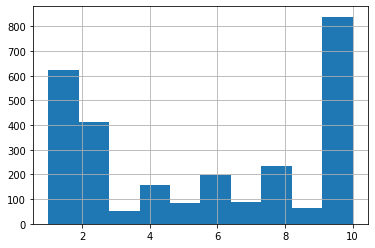

In [ ]:
df.score.hist()

In [ ]:
df[df.score==7].sample(50)

,review,score
573,"코믹이랑 액션신, CG는 그럭저럭 괜찮아여.",7
1609,그럭저럭 킬링타임으로 보기 좋은영화예요 중간에 졸긴 했지만 무난하게 보기 좋아요!,7
2755,"볼만한, 4D로 보면 생생해서 쪼아요",7
2709,대사나 발성은 좀 오글거리긴 하는데 웃음포인트 재밌고 바다나오는 씬은 연출 볼만함,7
9,한효주 연기가..정말..ㅎ턱 치켜들고 중2병 온거같았음,7
2,형 만한 아우 있기 어렵다는 옛말이 오늘 따라 실시간 뉴스에 나오는 말 같다.,7
2598,"누가 나오지, 어떤 내용인지도 잘 모르고 코로나때문에 몇년만에 남자친구랑 영화를 봤...",7
502,재미있게 잘봤습니다,7
2752,재미요소는 정말 많아서 재밌게 봤습니다:)해적1을 너무 재밌게 봐서 기대감이 높아서...,7
461,솔직히 1편이 너무 압권이라 기대하고 봤는데...좀 실망스럽네요,7


- 분석결과
  1. 5점까지는 부정적인 리뷰가 대다수, 6점부터는 긍정적인 리뷰가 우세
  2. 1 - 5점까지는 부정 리뷰, 6 - 10점까지는 긍정리뷰로 분류

- 분류

In [ ]:
def rating_to_label(rating):
  if rating >= 6:
      return 1
  else:
      return 0
    
df['y'] = df['score'].apply(lambda x: rating_to_label(x))

In [ ]:
df.y.value_counts()

1    1421
0    1333
Name: y, dtype: int64

### 2) 모델 학습

- train, test 데이터셋 생성

In [ ]:
X = tf_idf_vect
y = df['y']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1927, 2558), (1927,), (827, 2558), (827,))

- 모델 학습 (LogisticRegression Model)

In [ ]:
lr = LogisticRegression(random_state = 0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

- 성능 평가

In [ ]:
print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.2f' % precision_score(y_test, y_pred))
print('recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

accuracy: 0.69
precision: 0.67
recall: 0.71
F1: 0.69


- confusion matrix

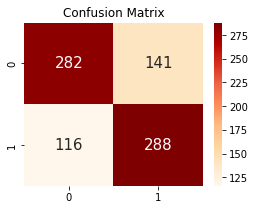

In [ ]:
confu = confusion_matrix(y_true = y_test, y_pred = y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

- 정리
  1. text 받기
  2. text_cleaning 작업 시행( 한국어 추출 -> 명사 형태소 추출 -> 길이 1미만 단어 제거 -> 불용어 제거 )
  3. CounterVectorizer 이용 학습 가능 데이터셋으로 전환( like one-hot encoding )
  4. TF-IDF 변환

In [ ]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
invert_index_vectorizer

In [ ]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = True)

for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

생각 2.3722001046772347
강하늘 2.2006379379597973
가족 1.9398812244931654
최고 1.7777076703121144
나름 1.7456514234678464
액션 1.5960271980227052
상미 1.4705978363126833
기대 1.4380369062481981
아이 1.4280839424926957
추천 1.426460364464036
보기 1.3023666781749073
하드캐리 1.2639387469864785
개인 1.2426154768502649
오세훈 1.2132390034737464
평점 1.194604241044086
꿀잼 1.192541010222824
킬링타임 1.1527498784669281
보고 1.0929763873629699
완전 1.082441664240697
아무 1.0817385154679444


In [ ]:
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = False)

for coef in coef_neg_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

최악 -2.9532441677021826
노잼 -2.2956022367031594
처음 -2.0486832167006117
감독 -1.957999013738305
개연 -1.716540628641725
수준 -1.7069195859541648
전작 -1.4819678789289734
망작 -1.4744364429858041
제발 -1.439678674104383
감상 -1.4220972867802206
김남길 -1.3471493209606042
쓰레기 -1.3462348724249111
화보 -1.2418085977687465
시간 -1.152427993016407
일단 -1.092501047866976
얼마나 -1.0592619968907495
이하 -1.0465028999059944
보지 -1.0417731397304877
억지 -1.0041346955530437
무슨 -1.0036020542897515


In [ ]:
def review_analysis(txt):
  test_df = df.copy()
  test_df.loc[9999] = [txt,0,0]
  countvector = CountVectorizer(tokenizer = lambda x: text_cleaning(x)) # tokenizer : text 전처리 방식
  encoding_vect = countvector.fit_transform(test_df['review'].tolist()) # fit_transform : 학습 데이터셋 생성(X데이터)

  tfidf_vector = TfidfTransformer()
  tf_idf_vector = tfidf_vector.fit_transform(encoding_vect)

  X = tf_idf_vector[:-1]
  y = test_df['y'].iloc[:-1]
  test = tf_idf_vector[-1]
  print(test)

  lr = LogisticRegression(random_state = 0)
  lr.fit(X, y)
  pred = int(lr.predict(test))

  if( pred==1 ):
    print("긍정적인 리뷰입니다.")
  else:
    print("부정적인 리뷰입니다.")

  return pred

In [ ]:
review_analysis('개꿀잼입니다.')

  (0, 73)	1.0
긍정적인 리뷰입니다.


1